In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn(self.conv(x)))
        out = out + self.shortcut(x)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=None):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.block1 = ResidualBlock(32, 64)
        self.block2 = ResidualBlock(64, 128)

        self.fc1 = nn.Linear(128 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = self.block1(x)
        x = self.pool(x)

        x = self.block2(x)
        x = self.pool(x)

        x = x.view(-1, 128 * 2 * 2)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [10]:
def evaluate(model, criterion, data_loader):
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [11]:
class CharacterDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

        self.data = self.data.view(-1, 1, 20, 20).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [27]:
train_data = torch.load('/content/drive/MyDrive/preprocessed_data_train.pt')
val_data = torch.load('/content/drive/MyDrive/preprocessed_data_val.pt')
test_data = torch.load('/content/drive/MyDrive/preprocessed_data_test.pt')

train_dataset = CharacterDataset(train_data['train_data'], train_data['train_labels'])
val_dataset = CharacterDataset(val_data['val_data'], val_data['val_labels'])
test_dataset = CharacterDataset(test_data['test_data'], test_data['test_labels'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = ResNet(num_classes=train_data['train_labels'].max().item() + 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

def train(model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs):
    train_losses = []
    val_losses = []
    test_losses = []
    val_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs} starting...")
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 0:
                print(f"  Processing batch {i}/{len(train_loader)}")
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss, val_accuracy = evaluate(model, criterion, val_loader)
        test_loss, test_accuracy = evaluate(model, criterion, test_loader)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, val_losses, test_losses, val_accuracies, test_accuracies

train_losses, val_losses, test_losses, val_accuracies, test_accuracies = train(model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs=10)

<ipython-input-27-f03d56ccf728>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load('/content/drive/MyDrive/preprocessed_data_train.pt')
<ipython-input-

Epoch 1/10 starting...
  Processing batch 0/5205
  Processing batch 100/5205
  Processing batch 200/5205
  Processing batch 300/5205
  Processing batch 400/5205
  Processing batch 500/5205
  Processing batch 600/5205
  Processing batch 700/5205
  Processing batch 800/5205
  Processing batch 900/5205
  Processing batch 1000/5205
  Processing batch 1100/5205
  Processing batch 1200/5205
  Processing batch 1300/5205
  Processing batch 1400/5205
  Processing batch 1500/5205
  Processing batch 1600/5205
  Processing batch 1700/5205
  Processing batch 1800/5205
  Processing batch 1900/5205
  Processing batch 2000/5205
  Processing batch 2100/5205
  Processing batch 2200/5205
  Processing batch 2300/5205
  Processing batch 2400/5205
  Processing batch 2500/5205
  Processing batch 2600/5205
  Processing batch 2700/5205
  Processing batch 2800/5205
  Processing batch 2900/5205
  Processing batch 3000/5205
  Processing batch 3100/5205
  Processing batch 3200/5205
  Processing batch 3300/5205
  P

In [28]:
torch.save(model.state_dict(), 'model_Version_Two_10_epochs.pth')

metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_losses': test_losses,
    'val_accuracies': val_accuracies,
    'test_accuracies': test_accuracies
}

torch.save(metrics, 'metrics_model_one_10_epochs.pth')

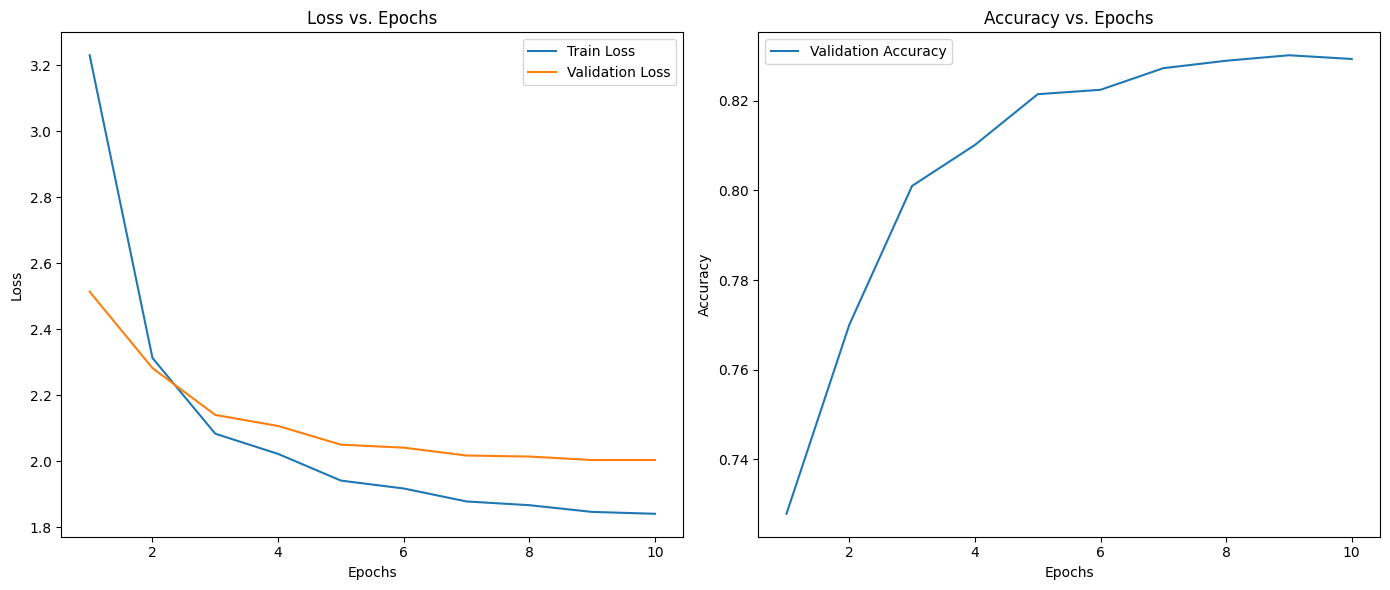

In [29]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_data = torch.load('preprocessed_data_train.pt')
val_data = torch.load('preprocessed_data_val.pt')
test_data = torch.load('preprocessed_data_test.pt')

train_dataset = CharacterDataset(train_data['train_data'], train_data['train_labels'])
val_dataset = CharacterDataset(val_data['val_data'], val_data['val_labels'])
test_dataset = CharacterDataset(test_data['test_data'], test_data['test_labels'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = ResNet(num_classes=train_data['train_labels'].max().item() + 1)

model.load_state_dict(torch.load('model_Version_One.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=65534, bias=True)
)

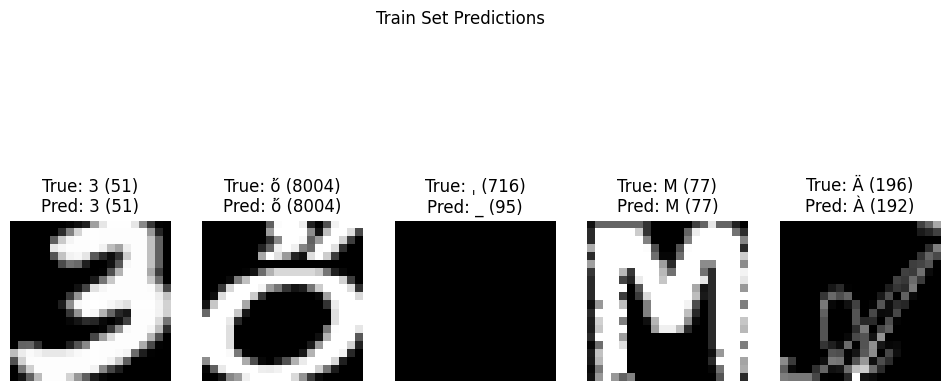

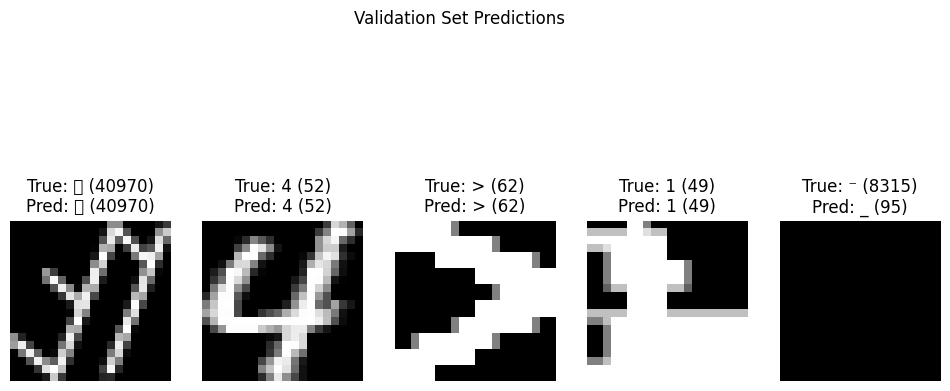

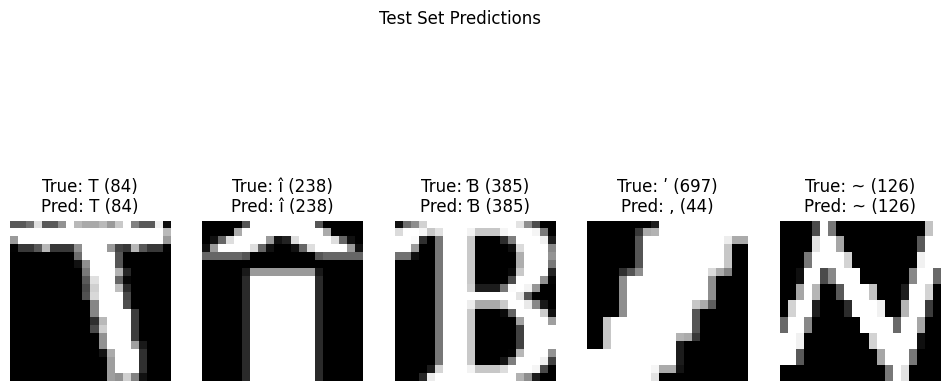

In [31]:
def show_predictions(model, data_loader, dataset_split, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images[:num_images], labels[:num_images]

    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze().cpu(), cmap='gray')
        plt.title(f"True: {chr(labels[i].item())} ({labels[i].item()})\nPred: {chr(preds[i].item())} ({preds[i].item()})")
        plt.axis('off')
    plt.suptitle(f'{dataset_split} Set Predictions')
    plt.show()

# Example usage:
show_predictions(model, train_loader, 'Train')
show_predictions(model, val_loader, 'Validation')
show_predictions(model, test_loader, 'Test')